<a href="https://colab.research.google.com/github/ElenaBianchini/ColoringGrayscaleImages/blob/main/ProgettoLabIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto di Laboratorio di Intelligenza Artificiale e Grafica Interattiva**

# Import

In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage import color
from PIL import Image

# Impostazione dei parametri

In [4]:
num_epochs = 50
batch_size = 8
learning_rate = 1e-3
use_gpu = torch.cuda.is_available()

In [70]:
if use_gpu:
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

# Paths

In [5]:
root_path = "/content/drive/MyDrive/COCO"

In [6]:
train_folder = root_path+"/train2014/"
val_folder = root_path+"/val2014/"
test_folder = root_path+"/test2014/"

# Dataset

In [7]:
def loadImagesName(dir_path):
    images_list = []
    count = 1
    for image_name in os.listdir(dir_path):
      filename = os.path.join(dir_path, image_name)
      images_list.append(filename)
      print("\rImage num: {}".format(count), end='')
      count = count+1
    
    return images_list


In [8]:
train_list = loadImagesName(train_folder)

Image num: 82805

In [9]:
val_list = loadImagesName(val_folder)

Image num: 40504

In [10]:
test_list = loadImagesName(test_folder)

Image num: 30679

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(612, 612)
(612, 612, 3)


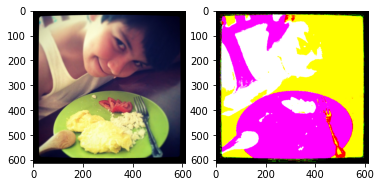

In [44]:
img = Image.open(val_list[0])
print(img.size)
img_lab = color.rgb2lab(img)
print(img_lab.shape)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(img_lab)

plt.show()

In [64]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, images_list):
    self.images_list = images_list
    self.img_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.Lambda(self.import_image),
      transforms.ToTensor(),                                
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # RESNET si aspetta immagini preprocessate così
    ])

  def __len__(self):
    return len(self.images_list)
  
  def __getitem__(self, idx):
    img = Image.open(self.images_list[idx]).convert('RGB')
    img = self.img_transform(img)
    return img

  # converto ogni immagine in un tensore pytorch contenente un'immagine LAB
  def import_image(self, img):
    return color.rgb2lab(img) 



In [67]:
train_dataset = ImageDataset(train_list)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [66]:
val_dataset = ImageDataset(val_list)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [68]:
test_dataset = ImageDataset(test_list)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [69]:
for _, data in enumerate(test_dataloader):
  print(data.shape)
  break

torch.Size([8, 3, 224, 224])


# Regressione

## Modello

In [53]:
class ColorizationRNet(nn.Module):
  def __init__(self):
    super(ColorizationRNet, self).__init__()

    # Importo ResNet che userò per estrarre le features dalle immagini
    resnet = torchvision.models.resnet18()
    # Cambio il primo livello di convoluzione di ResNet per accetta input con un solo canale
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Estraggo le feature dalle immagini
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    # Livelli di deconvoluzione:
    self.deconv = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
    )

  def forward(self, x):
    x = self.midlevel_resnet(x)
    output = self.deconv(x)
    return output

In [54]:
reg_net = ColorizationRNet()

## Funzione di costo e di ottimizzazione

In [55]:
optimizer = torch.optim.Adam(params=reg_net.parameters(), lr=learning_rate)
loss = nn.MSELoss()

## Train

In [ ]:
def train():
  

## Validation

In [ ]:
def validation():
  

## Grafico della curva di apprendimento

## Valutazione sul Test Set

## Risultato su un'immagine del Test Set

# Classificazione 

## Modello

In [ ]:
class ColorizationCNet(nn.Module):
  def __init__(self):
    super(ColorizationCNet, self).__init__()

    self.network = nn.Sequential(
        nn.Conv2d(1,64,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(64,64,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64,128,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128,256,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(256,512,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),

        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=2, dilatation=2),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=2, dilatation=2),
        nn.ReLU(),
        nn.BatchNorm2d(512),

        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=2, dilatation=2),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=2, dilatation=2),
        nn.ReLU(),
        nn.BatchNorm2d(512),

        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(512,512,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),

        nn.ConvTransposed2d(512, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),

        nn.Conv2d(256, 313, kenel_size=1, stride=1, padding=0),
        nn.Softmax(dim=1),
        nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1),
        nn.Upsample(scale_factor=4)
    )


  def forward(self, x):
    output = self.network(x)
    return output

In [ ]:
clas_net = ColorizationCNet()

## Funzione di costo e di ottimizzazione

## Train

## Grafico della curva di apprendimento

## Valutazione sul Test Set

## Risultato su un'immagine del Test Set